test generator

In [1]:
pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from skimage.draw import *

In [3]:
def generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength,sigma_blur, class_nbr=1):
    def ellipse(x,y):
        return (((x-c_x)*np.cos(alpha) + (y-c_y)*np.sin(alpha) ) / x_radius) ** 2 + (((x-c_x)*np.sin(alpha) - (y-c_y)*np.cos(alpha)) / y_radius) ** 2 - 1
    
    img = [[ellipse(x,y) for x in range(img_size)] for y in range(img_size)]
    noise = np.random.normal(0,noise_strength,(img_size,img_size))
    blur = gaussian_filter(noise,sigma=sigma_blur)
    img = np.where(np.array(img) + blur < 0, class_nbr, 0)
    return img

In [4]:
def generate_cells(nb_cells,img_size, base_img = None, class_nbr=1):
    if base_img == None:
        img = np.zeros((img_size,img_size))
    else:
        img = base_img
    i = 0
    while i < nb_cells:
        c_x = np.random.randint(-10, img_size + 10)
        c_y = np.random.randint(-10, img_size + 10)
        x_radius = np.random.randint(15,30)
        y_radius = np.random.randint(15,30)
        alpha = np.random.uniform(0,2 *np.pi)
        temp_img = generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength = 2,sigma_blur=3.7, class_nbr = 1)
        if(np.sum(np.multiply(img,temp_img)) == 0):
            i+=1
            img+=temp_img
    return img

In [5]:
pip install perlin_noise

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from perlin_noise import PerlinNoise

def perlin():
    noise = PerlinNoise(octaves=10)
    h = 256
    w = 256
    mask = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            mask[i, j] = noise([(i / h)*0.15, (j / w)*0.15])

    # Normalize to range 0.7–1.3
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = 0.7 + mask * 0.6
    return mask



In [7]:
def plot_cell(img,caption):
    fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax1.imshow(img,cmap='gray')
    ax1.set_title(caption,fontsize=16)
    ax1.axis('off')
    plt.show()

## Functions to add texture

In [8]:
def add_camera_noise(final_img,
                     exposure=20.0,     # photons per image intensity unit (higher -> stronger shot noise)
                     gain=1.0,          # electrons per photon (or conversion factor, often 1)
                     read_noise_sigma=2.0,  # Gaussian read noise (in electrons)
                     clip_range=(0, None)):


    signal = np.clip(final_img, 0, None)

    expected_photons = signal * exposure

    photons = np.random.poisson(expected_photons)

    electrons = photons * gain

    noisy_electrons = electrons + np.random.normal(0, read_noise_sigma, electrons.shape)

    noisy_image = noisy_electrons / (exposure * gain)

    noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1] if clip_range[1] is not None else noisy_image.max())

    return noisy_image

In [10]:
def add_correlated_noise(img, strength=0.15, beta=1.5):
   
    h, w = img.shape
    noise = np.random.normal(0, 1, (h, w))

    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    f = np.sqrt(fx*fx + fy*fy)
    f[0,0] = 1 

    filt = 1 / (f**beta)
    colored = np.real(np.fft.ifft2(np.fft.fft2(noise) * filt))
    colored = (colored - colored.min()) / (colored.max() - colored.min())

    return img + colored * strength

In [11]:
def add_internal_texture(img, mask):
    texture = gaussian_filter(np.random.normal(0, 1, img.shape), sigma=3)
    return img + texture * 0.15 * mask

In [12]:
def airy_psf(img, radius=1.5):
    from scipy.special import j1
    h, w = img.shape
    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    r = np.sqrt(fx*fx + fy*fy)
    psf = (2 * j1(2*np.pi*radius*r) / (2*np.pi*radius*r + 1e-6))
    filtered = np.fft.ifft2(np.fft.fft2(img) * psf)
    return np.real(filtered)

In [13]:
def smooth_mask(mask, sigma=2.0, edge_softness=12):
    blurred = gaussian_filter(mask.astype(float), sigma=sigma)
    blurred = (blurred - blurred.min()) / (blurred.max() - blurred.min())
    smooth = 1 / (1 + np.exp(-edge_softness * (blurred - 0.5)))
    return smooth

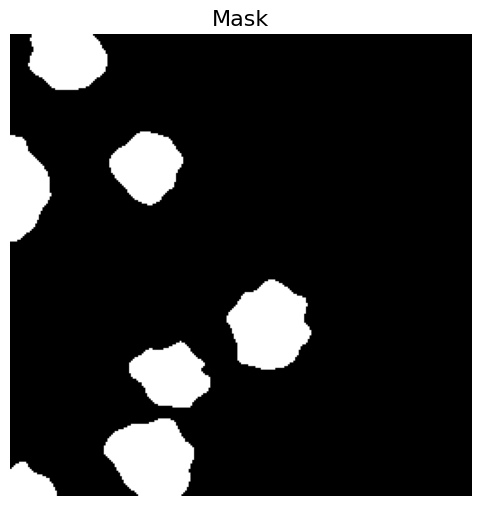

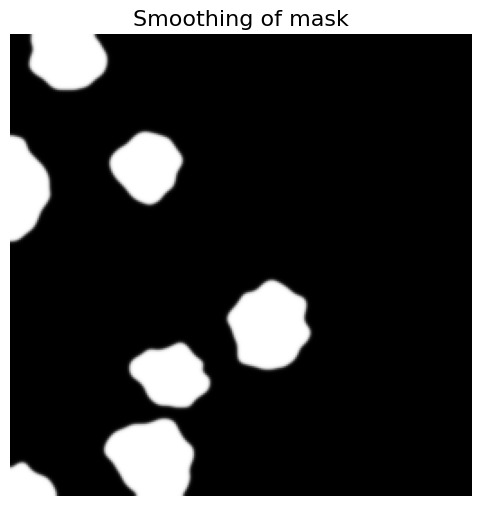

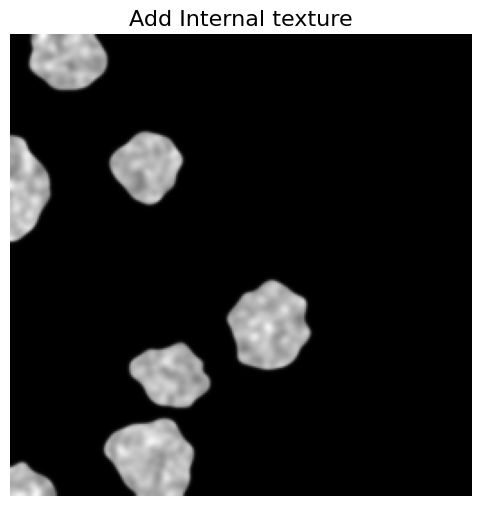

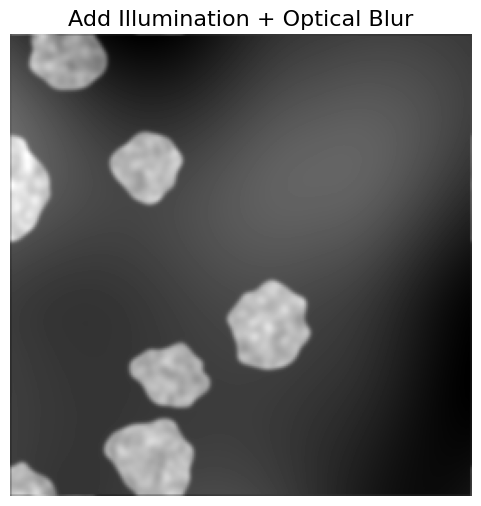

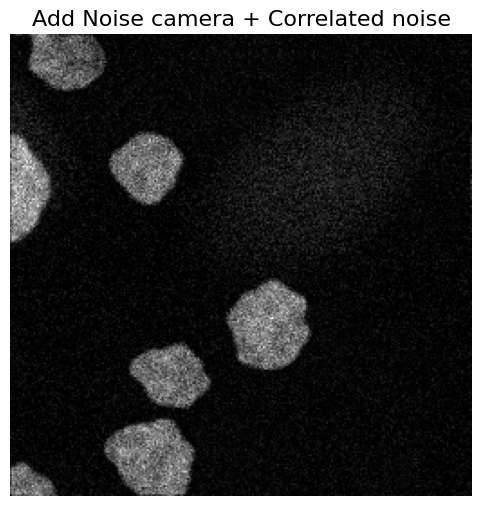

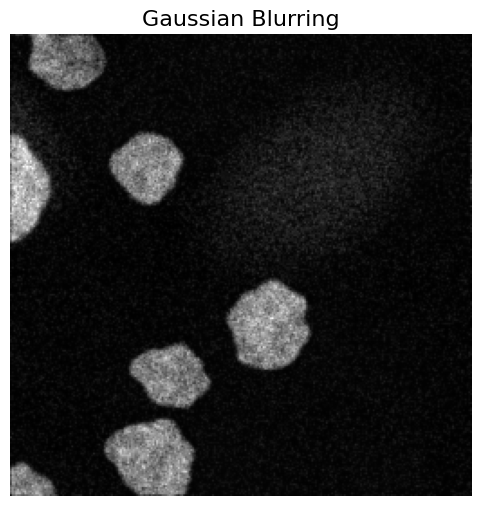

In [35]:
img = np.zeros((500, 500, 3))
mask = generate_cells(7,256)
plot_cell(mask,'Mask')
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
#Soft edges
soft = smooth_mask(mask)
plot_cell(soft,'Smoothing of mask')
img = bg_noise * (1 - soft) + cell_1_noise * soft
#Internal texture
img = add_internal_texture(img, mask)
plot_cell(img,'Add Internal texture')
#Perlin noise
illum = perlin()
img += illum*3.5
#Noise 
img = airy_psf(img)
plot_cell(img,'Add Illumination + Optical Blur')
# Poisson noise
img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
img = add_correlated_noise(img, strength=0.08, beta=1.4)
plot_cell(img,'Add Noise camera + Correlated noise')
img = gaussian_filter(img,sigma = 0.5)
plot_cell(img,'Gaussian Blurring')

In [ ]:
from skimage import io, util
import os

def save_image(image,mask,path,name):
    image_u8 = util.img_as_ubyte(image/np.max(np.abs(image)))
    io.imsave(os.path.join(path,'images',  f"{name}.png"), image_u8)
    mask_u8 = util.img_as_ubyte(mask/np.max(np.abs(mask)))
    io.imsave(os.path.join(path,'masks',  f"{name}.png"), mask_u8)

    image = image.astype(np.float32)
    io.imsave(os.path.join(path,'images',  f"{name}.tif"), image)
    mask = mask.astype(np.float32)
    io.imsave(os.path.join(path,'masks',  f"{name}.tif"), mask)

In [15]:
import cv2

def morphological_filters(img, kernel, iterations):
    img_erosion = cv2.erode(img, kernel, iterations=iterations)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations) 
    return img_dilation

def morphological_filters_2(img, kernel_er,kernel_dil, iterations_er,iterations_dil):
    img_erosion = cv2.erode(img, kernel_er, iterations=iterations_er)
    img_dilation = cv2.dilate(img_erosion, kernel_dil, iterations=iterations_dil) 
    return img_dilation

In [ ]:
path = 'dataset/generated_cells/masks/'
new_path = 'dataset/eroded-dilated_0.67/masks/'
from skimage import io, util
import os
for i in range(1,100):
    # Morphological filters
    if i not in [57,58,59]:
        old_mask = cv2.imread(f'{path}img_{i}.png')

        kernel_er = np.ones((6,6), np.uint8)
        iterations_er = 4
        kernel_dil = np.ones((6,6), np.uint8)
        iterations_dil = 4
        mask = morphological_filters_2(old_mask, kernel_er,kernel_dil, iterations_er,iterations_dil) / 255

        # SAVE MASK
        mask_u8 = util.img_as_ubyte(mask)
        io.imsave(f'{new_path}img_{i}.png', mask_u8)

        mask = mask.astype(np.float32)
        io.imsave(f'{new_path}img_{i}.tif', mask)



In [38]:
for i in range(10):
    number_cells = np.random.randint(3, 5) # random number of cells
    mask = generate_cells(number_cells,256)
    img = mask

    # NOISE 

    bg_noise = np.zeros((256,256))
    cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
    #Soft edges
    soft = smooth_mask(mask)
    img = bg_noise * (1 - soft) + cell_1_noise * soft
    #Internal texture
    img = add_internal_texture(img, mask)
    #Perlin noise
    illum = perlin()
    img += illum*3.5
    #Noise 
    img = airy_psf(img)
    # Poisson noise
    img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
    img = add_correlated_noise(img, strength=0.08, beta=1.4)
    img = gaussian_filter(img,sigma = 0.5)
    
    # SAVE IMAGE + MASK Uncomment to save the images
    # path = 'dataset/generated_cells'
    # save_image(img, mask, path,f"img_{i}")

Apply erosion and dilation

In [40]:
#pip install opencv2-python

0.908858950806287


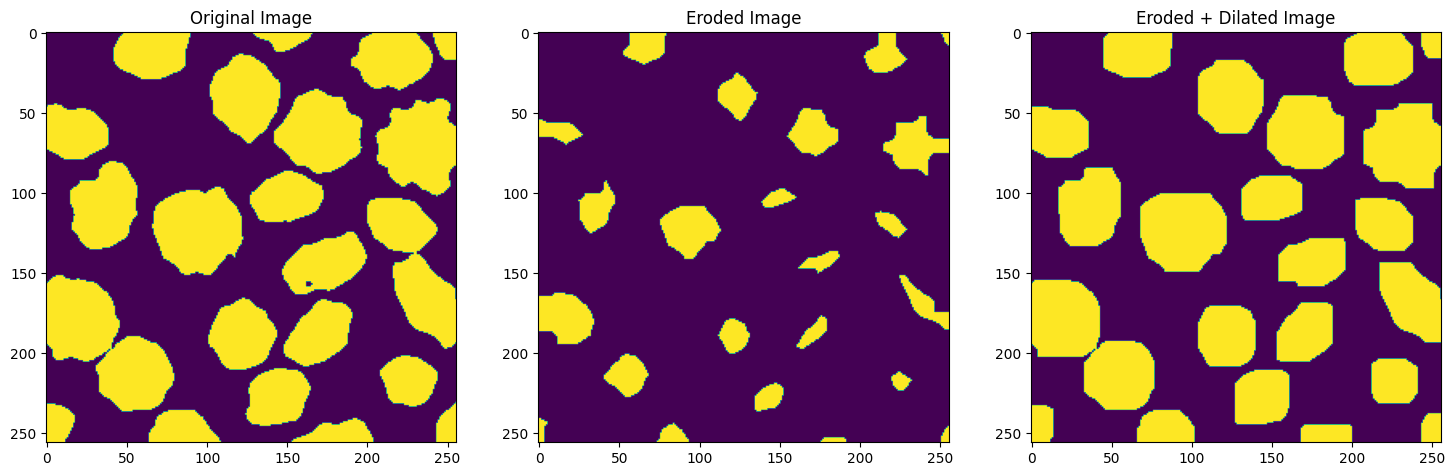

In [41]:
import cv2
from sklearn.metrics import jaccard_score
kernel = np.ones((5,5), np.uint8)
img = cv2.imread('dataset/generated_cells/masks/img_82.png')[:,:,0] / 255
iterations = 4
img_erosion = cv2.erode(img, kernel, iterations=iterations)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)    # Restores the size of cells

# plot three images side by side
print(jaccard_score(img.reshape(-1),img_dilation.reshape(-1)))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(img)
ax2.imshow(img_erosion)
ax3.imshow(img_dilation)
ax1.set_title('Original Image')
ax2.set_title('Eroded Image')
ax3.set_title('Eroded + Dilated Image')
plt.show()

0.6759457530335474


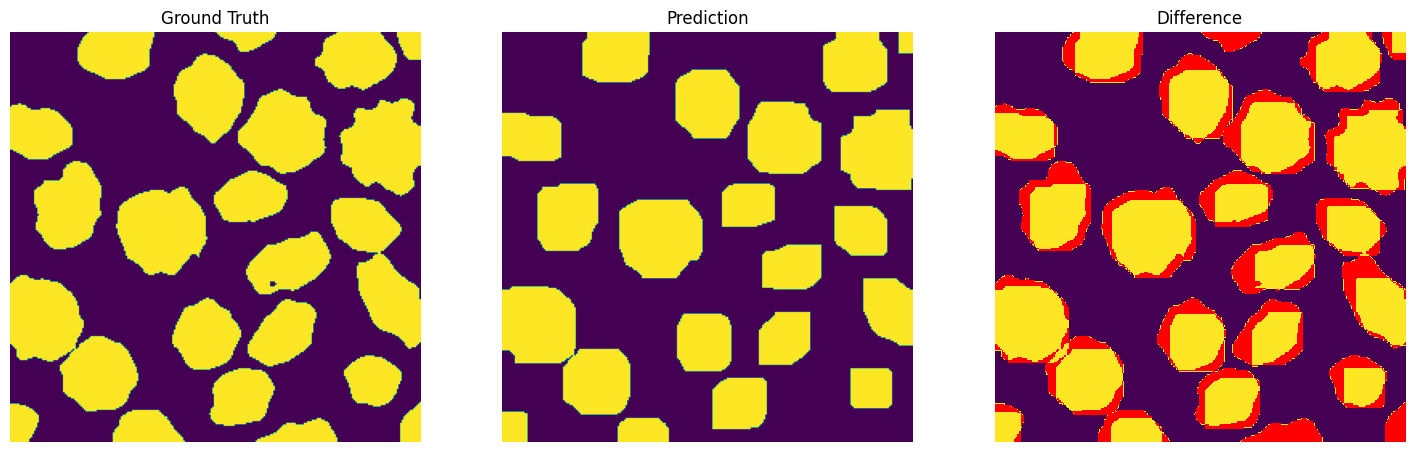

In [44]:
import cv2
from sklearn.metrics import jaccard_score
from matplotlib.colors import ListedColormap
kernel = np.ones((6,6), np.uint8)
img = cv2.imread('dataset/generated_cells/masks/img_82.png')[:,:,0] / 255
iterations = 4
img_erosion = cv2.erode(img, kernel, iterations=iterations)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)    # Restores the size of cells

# plot three images side by side
print(jaccard_score(img.reshape(-1),img_dilation.reshape(-1)))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Define your custom color palette
custom_colors = ["#440154","#440154","#440154", "#fde724","#fde724","#fde724","#ff0000","#ff0000","#ff0000"]

# Create a ListedColormap
custom_cmap = ListedColormap(custom_colors)


diff = np.where(((img == 0) & (img_dilation == 1)) | ((img == 1) & (img_dilation == 0)),1,np.where(img == 1,0.5,0))
# plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img);  plt.title("Ground Truth");  plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(img_dilation);plt.title("Prediction");    plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(diff,cmap=custom_cmap);plt.title("Difference");    plt.axis('off')
plt.show()

In [45]:
def morphological_filters(img, kernel, iterations):
    img_erosion = cv2.erode(img, kernel, iterations=iterations)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)
    return img_dilation

Define several core functions
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


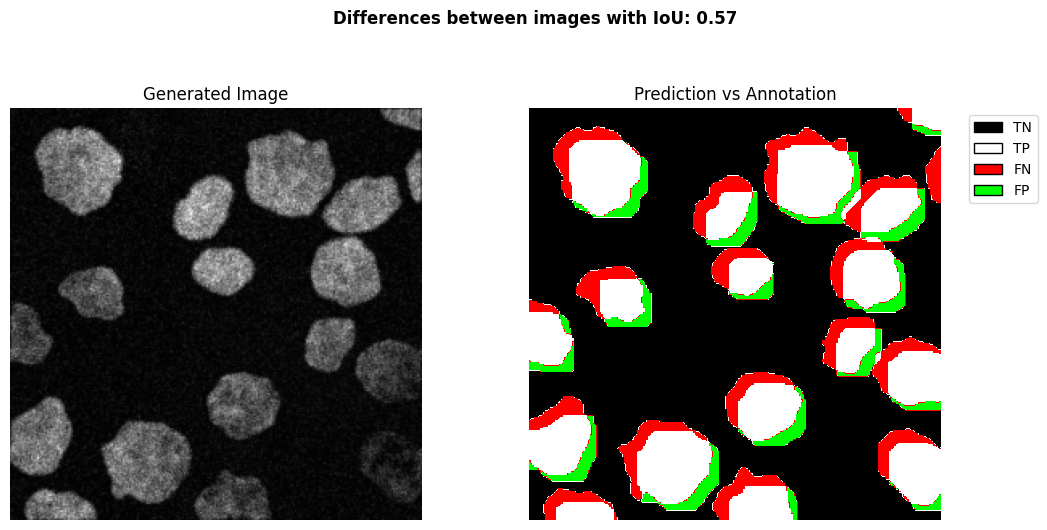

In [46]:
import cv2
from matplotlib.colors import ListedColormap
import data_loader 
nb = 17
iou = 0.57
mask = cv2.imread(f'dataset/generated_cells/masks/img_{nb}.png')[:,:,0] / 255
image = cv2.imread(f'dataset/generated_cells/images/img_{nb}.png')[:,:,0] / 255
iou_img = cv2.imread(f'dataset/eroded-dilated_{iou}/masks/img_{nb}.png')[:,:,0] / 255

plt = data_loader.visualize_img2(image, mask, iou_img, iou)
plt.savefig(f"Difference_with_iou_{iou}.png")
plt.show()